<a href="https://colab.research.google.com/github/tessytom/content-creation/blob/main/Vicious_Visionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install dependencies
!pip install torch_intermediate_layer_getter --quiet
!pip install Pillow --quiet
!pip install pytorch_lightning --quiet

In [ ]:
#@title Connect Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title load CIFAR-10-C Data
# !wget 'https://zenodo.org/record/2535967/files/CIFAR-10-C.tar'
# !tar -xvf "CIFAR-10-C.tar" -C '/content/drive/MyDrive/NMA_DL_project/CIFAR-10-C'

In [ ]:
#@title Imports
import random
import time

import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
# For getting output of intermediate layers in Pytorch
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
# For interactive visualization
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
import torchvision.models as models

import pytorch_lightning

from sklearn.model_selection import KFold

import copy 
import pickle as pkl 

from functools import partial
import collections

import numpy as np
from scipy.stats import spearmanr, pearsonr, rankdata
from functools import partial
from scipy.spatial.distance import squareform

%load_ext tensorboard

In [ ]:
#@title Helper functions
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

# function to compute accuracy (could be probably implemented in a better way)
def accuracy(outputs, labels):
  correct_pred=0
  total_pred=0
  predictions = torch.argmax(outputs,dim=1)
  for label, prediction in zip(labels, predictions):
    if label == prediction:
      correct_pred += 1
    total_pred += 1
  accuracy = correct_pred/total_pred
  return accuracy

# function to plot the trianing loss and accuracy and the test accuracy
def plot_train_loss_acc(losses, accuracies_train, accuracies_test, fext):
    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].plot( losses, label='Training Loss' )
    axs[0].set_xlabel('epochs') ; axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot( accuracies_train, label='Training Accuracy' )
    axs[1].plot( accuracies_test, label='Test Accuracy' )
    axs[1].set_xlabel('epochs') ; axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim([0.0,1.05])
    axs[1].legend()
    fig.tight_layout(pad=3.0)
    plt.savefig(fext, bbox_inches='tight')

# function to show image 
def imshow(img):
    img = img/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# function to show some of the images 
def show_sample_images(dataloader): 
  # get some random training images
  dataiter = iter(dataloader)
  images, labels = dataiter.next()
  print(images.size())
  # show images
  imshow(torchvision.utils.make_grid(images))
  # setup labels 
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  # print labels
  print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

def test_function(model,fig_savepath,res_savepath, **kwargs): 

  # set model in eval mode 
  model.eval()
  # initialize accuracy dict 
  all_accuracies = dict()
  
  #loop through test sets
  for test_name, test_set in kwargs.items(): 

    # first create data loader 
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                         shuffle=False, num_workers=2)

    # start testing here
    test_acc = []#0.0
    for i, data in enumerate(test_loader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

      with torch.no_grad():
        outputs = model(inputs)
        test_acc.append(accuracy(outputs, labels))

    all_accuracies[test_name] = np.array(test_acc).mean()

  #basic bar plot 
  plt.bar(all_accuracies.keys(), all_accuracies.values())
  plt.tick_params(axis='x', which='major', labelsize=10)
  plt.xticks(rotation=90)
  plt.savefig(fig_savepath, bbox_inches='tight')

  #save accuracies 
  with open(res_savepath+'.pickle', 'wb') as handle:
    pkl.dump(all_accuracies, handle, protocol=pkl.HIGHEST_PROTOCOL)

  return all_accuracies 

def get_activation(name):
  def hook(model, input, output):
      this_activation = output.detach()
      this_activation = this_activation.flatten().cpu().numpy()
      activations[name] = this_activation
  return hook

def make_RDM(activity_pattern_matrix, distance='pearson'):
    #TODO: implement for multiple matrices.
    #TODO: implement other distance norms 
    '''Compute dissimilarity matrix.
    
    Parameters
    ----------
    activity_pattern_matrix : ndarray
        Matrix which holds activity patterns for several conditions. Each
        column is one condition, each row one measurement channel.
    distance : str
        The desired distance measure.
        
    Returns
    -------
    rdm : ndarray
        Dissimilarity matrix indicating dissimilarity for all conditions in
        `activity_pattern_matrix`.
    '''
    if distance=='pearson':
        rdm = 1 - np.corrcoef(activity_pattern_matrix, rowvar=False)
    # elif distance=='Euclidian':
    #     rdm = 1 - np.corrcoef(activity_pattern_matrix, rowvar=False)
    return rdm

def flatten_RDM(rdm: np.ndarray) -> np.ndarray:
    '''Flatten the upper half of a dissimilarity matrix to a vector.
    
     Multiple dissimilarity matrices can be fed at once, requiring the shape 
     (n,n,m), where m denotes different matrices of shape (n,n).
    
    Parameters
    ----------
    rdm : ndarray
        The dissimilarity matrix which shall be flattened.
    
    Returns
    -------
    rdv : ndarray
        The unique upper half of `rdm`.
    
    '''
    if rdm.ndim==3:
        mapfunc = partial(squareform, checks=False)
        rdv = np.array(list(map(mapfunc, np.moveaxis(rdm, -1, 0)))).T
    elif rdm.ndim==2:
        rdv = rdm[np.triu_indices(rdm.shape[0], k=1)].reshape(-1,1)
    return rdv

def correlate_RDMs(rdv1, rdv2, score_type='pearson'):
    '''Relate two flattened dissimilarity matrices to each other
    
    Parameters
    ----------
    rdv1 : array_like
        First flattened dissimilarity matrix. 
    rdv2 : array_like
        Second flattened dissimilarity matrix.
    score_type : {'pearson', 'spearman'}, optional
        Type of association measure to compute (defaults to `pearson`).
        
    Return
    ------
    corr : float
        Correlation coefficient.
    p_value : float
        Two-tailed p-value.
    
    '''
    if score_type == 'pearson':
        corr, p_value = pearsonr(rdv1, rdv2)
    elif score_type == 'spearman':
        corr, p_value = spearmanr(rdv1, rdv2)
    return corr, p_value

def get_activations_and_RDMs(model,  plotting_on=False,**kwargs,):

  # set model in eval mode 
  model.eval()
  # initialize accuracy dict 
  all_RDMs = dict()
  all_activations = dict()

  # register forward hooks 
  activations = collections.defaultdict(list)

  # define function for saving activations 
  def save_activation(name, model, inp, out):
	  activations[name].append(out.to('cpu'))
  
  #check if model is VGG or simple model 
  if hasattr(model, 'features'): 
    pool_ct = 1
    fc_ct = 1
    for idx,layer in enumerate(model.features):
        if isinstance(layer,nn.MaxPool2d):
          layer.register_forward_hook(partial(save_activation,'Pool_'+ str(pool_ct))) 
          pool_ct +=1  
    for idx,layer in enumerate(model.classifier):
        if isinstance(layer, nn.ReLU):
          layer.register_forward_hook(partial(save_activation,'Fc_'+ str(fc_ct))) 
          fc_ct +=1
  else: 
    for name, m in model.named_children():
      if type(m)!=nn.Dropout:
        # partial to assign the layer name to each hook
        m.register_forward_hook(partial(save_activation, name))
    
  # loop through all test loaders that are given as keyword arguments 
  for test_name, test_set in kwargs.items(): 

    # first create data loader 
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)
    # a dictionary that keeps saving the activations as they come
    activations = collections.defaultdict(list)
    all_labels = [] 
    for i, data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
      inp, labels = data[0].to(DEVICE), data[1].to(DEVICE)

      with torch.no_grad():
        out = model(inp)
        all_labels.append(labels.to('cpu'))

    # concatenate all the outputs we saved to get the the activations for each layer for the whole dataset
    activations = {name: torch.cat(outputs, 0) for name, outputs in activations.items()}
    all_labels = torch.cat(all_labels, 0)

    # now rearrange and average the activations 
    category_activations = dict()

    for layer, activation in activations.items(): 

      activation = torch.flatten(activation, start_dim=1, end_dim=-1)

      layer_size = activation.size()[1]
      act_mat = np.zeros([10,layer_size])

      for cat in np.unique(all_labels): 

        this_activation = activation[all_labels == cat] 
        this_activation = torch.mean(this_activation,axis=0)
        act_mat[cat,:] = this_activation

      category_activations[layer] = act_mat

    all_activations[test_name] = category_activations
    #now compute RDMs 
    RDMs = dict()

    for layer, cat_activation in category_activations.items(): 

      this_RDM = make_RDM(cat_activation.transpose(), distance='pearson')

      if plotting_on:
        plt.figure()
        plt.imshow(this_RDM)

      RDMs[layer] = this_RDM 
    
    all_RDMs[test_name] = RDMs

  return all_activations, all_RDMs 

# define class for corrupted data 
class CorruptedDataset(torch.utils.data.Dataset):
    def __init__(self, path,file_name, severity_level, transform = None):
        self.imgs_path = path 
        file_name = self.imgs_path+file_name
        data = np.load(file_name)
        labels = np.load(self.imgs_path + 'labels.npy')

        if severity_level == 'high':
            self.data = data[-10000:]
            self.labels = labels[-10000:]
        elif severity_level == 'low':
            self.data = data[:10000]
            self.labels = labels[:10000]
        print(self.data.shape)
        self.class_map = {"airplane" : 0, "automobile" : 1, "bird" : 2, "cat" : 3,
                          "deer" : 4, "dog" : 5, "frog" : 6, "horse" : 7, "ship" : 8,
                          "truck" : 9}
        self.img_dim = (32,32)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, class_id = self.data[idx], self.labels[idx]
        class_id = torch.tensor([class_id], dtype=torch.long)
        if self.transform:
            img_tensor = self.transform(img)
        return img_tensor, class_id.squeeze()

def train_loop_noval(model, optimizer, criterion, trainloader, num_epochs =10): 

  # Run the training loop for defined number of epochs
  training_loss = []
  training_accuracy = []
  
  print(num_epochs)

  for epoch in range(0, num_epochs):

    # Print epoch
    # print(f'Starting epoch {epoch+1}')

    model.train()
    running_loss = 0.0
    acc = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # zero the parameter gradients
      optimizer.zero_grad()

        # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      acc = accuracy(outputs, labels)
      loss.backward()
      optimizer.step()

        # print statistics
      running_loss += loss.item()
    
    if (epoch + 1) % 1 == 0:
      print('[%d] epoch. Loss: %.3f. Training accuracy: %.3f'%
           (epoch + 1, running_loss, acc))
    training_loss.append(running_loss)
    training_accuracy.append(acc)
    
  return model, training_accuracy, training_loss

In [ ]:
#@title Set random seed 
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


In [ ]:
#@title Finetuning function - old 

def finetuning (model, optimizer, criterion, dataset_list, model_save_name, batch_size=100, num_epochs =10):

  # checking if GPU is available
  if torch.cuda.is_available():
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

  #concatenating the corrupted data for finetuning based on list
  dataset_corrup_concat = torch.utils.data.ConcatDataset(dataset_list)

  #load training data
  trainloader = torch.utils.data.DataLoader(dataset_corrup_concat, batch_size=batch_size, shuffle=True)

  #start train_loop_noval
  model, training_accuracy, training_loss = train_loop_noval(model, optimizer, criterion, trainloader, num_epochs)

  # Saving the model
  path = F"drive/MyDrive/{model_save_name}" 
  torch.save(model.state_dict(), path)


In [ ]:
#@title Model specification 
# @title Load a much simpler model (and overwrite)
class CNOTP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 18, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 36, 5)
        self.fc1 = nn.Linear(36 * 5 * 5, 120)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        # x = F.softmax(x)
        return x

model = CNOTP()
print(model)

CNOTP(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 36, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=900, out_features=120, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
#@title Define training loop 
def train_loop(model, optimizer, criterion, trainloader, valloader, num_epochs =10, early_stop_param=10): 

  # Run the training loop for defined number of epochs
  training_loss = []
  training_accuracy = []
  val_accuracy = []
  wait = 0 
  best_acc = 0
  
  print(num_epochs)

  for epoch in range(0, num_epochs):

    # Print epoch
    # print(f'Starting epoch {epoch+1}')

    model.train()
    running_loss = 0.0
    acc = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # zero the parameter gradients
      optimizer.zero_grad()

        # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      acc = accuracy(outputs, labels)
      loss.backward()
      optimizer.step()

        # print statistics
      running_loss += loss.item()

    # start testing here
    val_acc = []#0.0
    model.eval()
    for i, data in enumerate(valloader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

      with torch.no_grad():
        # forward + backward + optimize
        outputs = model(inputs)
        val_acc.append(accuracy(outputs, labels))
    
    val_accuracy.append(np.array(val_acc).mean())
    
    if (np.array(val_acc).mean() > best_acc):
      best_acc = np.array(val_acc).mean()
      best_epoch = epoch
      best_model = copy.deepcopy(model)
      wait = 0
    else:
      wait += 1

    if wait == early_stop_param:
       print('Early stepped at [%d] epoch. Loss: %.3f. Training accuracy: %.3f . Test accuracy: %.3f' %
           (epoch + 1, running_loss, acc, np.array(val_acc).mean()))
       training_loss.append(running_loss)
       training_accuracy.append(acc) 
       break 
    
    if (epoch + 1) % 1 == 0:
      print('[%d] epoch. Loss: %.3f. Training accuracy: %.3f . Test accuracy: %.3f' %
           (epoch + 1, running_loss, acc, np.array(val_acc).mean()))
    training_loss.append(running_loss)
    training_accuracy.append(acc)
    
  return best_model, best_acc, training_accuracy, training_loss, val_accuracy 

In [ ]:
#@title Load pretrained VGG19 model
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)
model.to(DEVICE)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
#@title VGG19 stuff
model = models.vgg19(pretrained = False, progress=True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
#print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#@title Training part 

transform_training = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize((224,224)),#
     transforms.RandomHorizontalFlip(p=0.2),
     transforms.RandomVerticalFlip(p=0.2),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]) #we set back this Normalization values because we could not train the model otherwise

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]) #we set back this Normalization values because we could not train the model otherwise

batch_size = 100 # that might be adjusted later on 

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform_training)

# k_folds = 5
# num_epochs = 200

# best_accs = []

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=k_folds, shuffle=True)
    
#   # Start print
# print('--------------------------------')

#   # K-fold Cross Validation model evaluation
# for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    
#     # Print
#   print(f'FOLD {fold}')
#   print('--------------------------------')
    
#     # Sample elements randomly from a given list of ids, no replacement.
#   train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)

#   val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

#   trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_subsampler)

#   valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, sampler=val_subsampler)

#   # Init the neural network
#   model = CNOTP()
    
#   # Initialize optimizer
#   optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#   criterion = nn.CrossEntropyLoss()
#   # checking if GPU is available
#   if torch.cuda.is_available():
#     model = model.to(DEVICE)
#     criterion = criterion.to(DEVICE)
    
#   best_model, best_acc, training_accuracy, training_loss, val_accuracy = train_loop(model, optimizer, criterion, trainloader, valloader, num_epochs = num_epochs, early_stop_param=10)

#   # Saving the model
#   model_save_name = f'./model-fold-{fold}.pth'
#   path = F"drive/MyDrive/{model_save_name}" 
#   torch.save(best_model.state_dict(), path)

#   # plot the training process 
#   plot_train_loss_acc(training_loss, training_accuracy, val_accuracy, f'model-fold-{fold}-training.png')

#   # keep track of the best accs
#   best_accs.append(best_acc)

# # print and save best accs 
# print(best_accs)
# savepath = '/content/drive/MyDrive/NMA_DL_project/'
# with open(savepath+'best_accs.pickle', 'wb') as handle:
#   pkl.dump(best_accs, handle, protocol=pkl.HIGHEST_PROTOCOL)


(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
Files already downloaded and verified


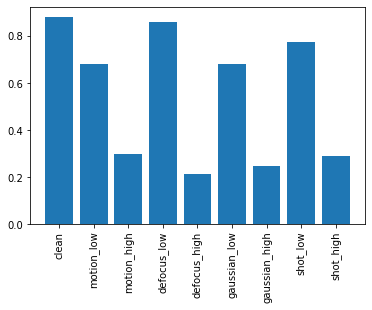

In [ ]:
#@title Testing part - naive model 

# # load the model 
# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# print(path)
# model = CNOTP()
# model.load_state_dict(torch.load(path))
# print(model)

# setup test loaders 
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]) #we set back this Normalization values because we could not train the model otherwise

batch_size = 100 # that might be adjusted later on 

corruption_type_list = ['motion_blur.npy', 'defocus_blur.npy', 'gaussian_noise.npy', 'shot_noise.npy']
severity_level = ['low', 'high']

img_path = '/content/drive/MyDrive/NMA_DL_project/CIFAR-10-C/CIFAR-10-C/'

motion_low = CorruptedDataset(img_path ,corruption_type_list[0], severity_level[0], transform=transform_test)
motion_high = CorruptedDataset(img_path , corruption_type_list[0], severity_level[1], transform=transform_test)
defocus_low = CorruptedDataset(img_path ,corruption_type_list[1], severity_level[0], transform=transform_test)
defocus_high = CorruptedDataset(img_path ,corruption_type_list[1], severity_level[1], transform=transform_test)

gaussian_low = CorruptedDataset(img_path, corruption_type_list[2], severity_level[0], transform=transform_test)
gaussian_high = CorruptedDataset(img_path, corruption_type_list[2], severity_level[1], transform=transform_test)
shot_low = CorruptedDataset(img_path, corruption_type_list[3], severity_level[0], transform=transform_test)
shot_high = CorruptedDataset(img_path, corruption_type_list[3], severity_level[1], transform=transform_test)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# test and plot 
fig_savepath = '/content/drive/MyDrive/NMA_DL_project/naive_test_acc_VGG19.png'
res_savepath = '/content/drive/MyDrive/NMA_DL_project/test_results_VGG19'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low, 
                               motion_high = motion_high, 
                               defocus_low = defocus_low,
                               defocus_high = defocus_high, 
                               gaussian_low = gaussian_low,
                               gaussian_high = gaussian_high,
                               shot_low = shot_low,
                               shot_high = shot_high) 


In [ ]:
#@title RSA part - only naive model  
#extract activations and compute RDMs 
all_activations, all_RDMs = get_activations_and_RDMs(model,
                               clean = testset, 
                               motion_low = motion_low, 
                               motion_high = motion_high, 
                               defocus_low = defocus_low,
                               defocus_high = defocus_high, 
                               gaussian_low = gaussian_low,
                               gaussian_high = gaussian_high,
                               shot_low = shot_low,
                               shot_high = shot_high) 

# Visualizing RSA results 
all_RDM_correlations = dict()

for test_idx, (test_name, RDMs) in enumerate(all_RDMs.items()): 

  if test_name == 'clean': 
    clean_RDMs = RDMs
    continue

  RDM_corr = dict()

  for layer_idx, (layer, RDM) in enumerate(RDMs.items()): 

    rdv1 = flatten_RDM(clean_RDMs[layer])
    rdv2 = flatten_RDM(RDM)
    corr, _  =  pearsonr(rdv1.squeeze(), rdv2.squeeze())
    
    RDM_corr[layer] =corr

  all_RDM_correlations[test_name] = RDM_corr

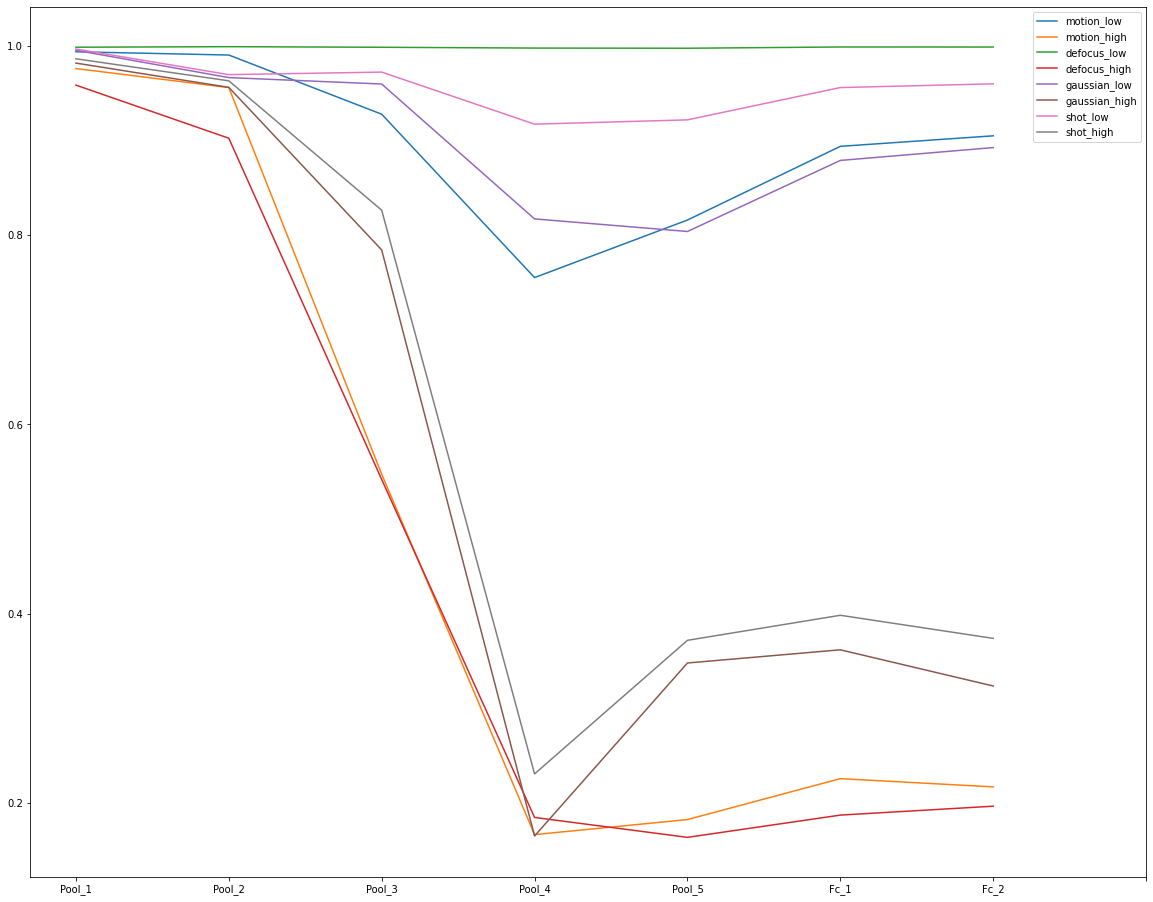

In [ ]:
#@title plot RDM correlations 

import pandas as pd
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1, 1, 1)
test_labels = []
layer_names = []

for test_name, RDM_corr in all_RDM_correlations.items(): 
  test_labels.append(test_name)
  if test_name == 'motion_low':
    for layer,_ in RDM_corr.items(): 
      layer_names.append(layer)

  df = pd.DataFrame(RDM_corr.items(), columns = ['Layer', 'Correlation'])

  df.plot(ax = ax)

plt.legend(test_labels)
plt.xticks([0,1,2,3,4,5,6,7], layer_names)
plt.show()

ValueError: ignored

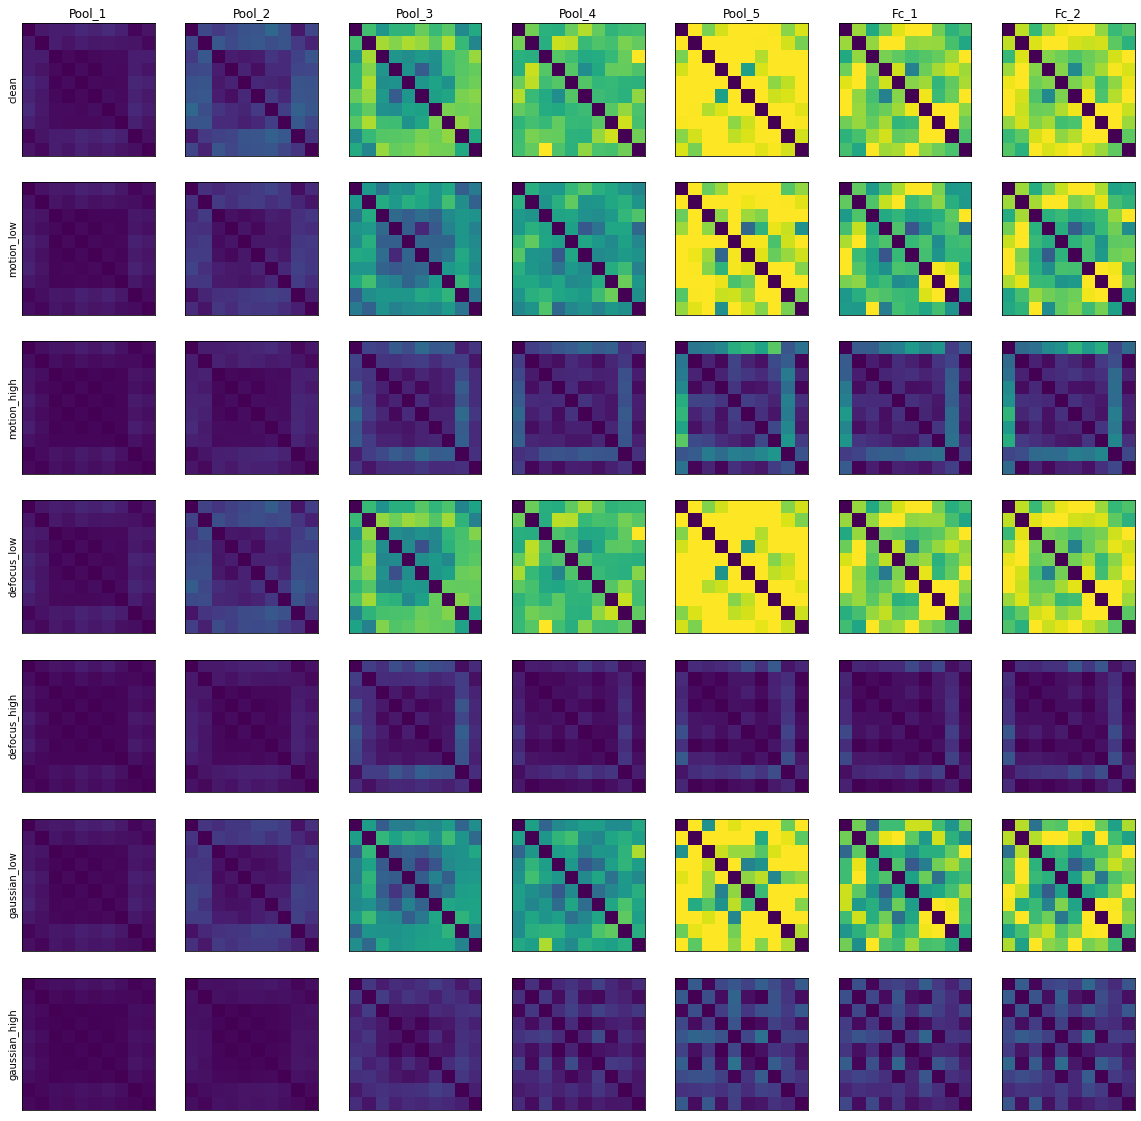

In [ ]:
#@title RDM plotting 
f = plt.figure(figsize=(20, 20))
ct = 1

for test_idx, (test_name, RDMs) in enumerate(all_RDMs.items()): 
  df = pd.DataFrame(RDMs.items())

  for layer_idx in range(len(RDMs.keys())):
    ax = f.add_subplot(7,len(RDMs.keys()),ct)
    ct += 1
    plt.imshow(df[1][layer_idx], vmin = 0, vmax = 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if layer_idx == 0: 
      ax.set_ylabel(test_name)
      ax.get_yaxis().set_visible(True)
      ax.set_yticks([])
    if test_idx ==0:
      plt.title(df[0][layer_idx])



In [ ]:
#@title Load fresh VGG19 model to avoid problems with hooks 
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)

In [ ]:
#@title Finetuning function

def finetuning (model, optimizer, criterion, dataset_list_train,dataset_list_test, model_save_name, batch_size=100, num_epochs =10):

  # checking if GPU is available
  if torch.cuda.is_available():
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

  #concatenating the corrupted data for finetuning based on list
  dataset_corrup_concat_train = torch.utils.data.ConcatDataset(dataset_list_train)
  dataset_corrup_concat_test = torch.utils.data.ConcatDataset(dataset_list_test)


  #load training data
  trainloader = torch.utils.data.DataLoader(dataset_corrup_concat_train, batch_size=batch_size, shuffle=True)

  #load test data
  testloader = torch.utils.data.DataLoader(dataset_corrup_concat_test, batch_size=batch_size, shuffle=True)

  #start train_loop_noval
  model, best_acc, training_accuracy, training_loss, test_accuracy = train_loop(model, optimizer, criterion, trainloader, testloader, num_epochs = num_epochs, early_stop_param=10)

  # Saving the model
  path = F"drive/MyDrive/{model_save_name}" 
  torch.save(model.state_dict(), path)


In [ ]:
#@title Split corrupted data into training and test datasets
motion_low_train, motion_low_test = torch.utils.data.random_split(motion_low, [8000, 2000])
motion_high_train, motion_high_test = torch.utils.data.random_split(motion_high, [8000, 2000])
gaussian_low_train, gaussian_low_test = torch.utils.data.random_split(gaussian_low, [8000, 2000])
gaussian_high_train, gaussian_high_test = torch.utils.data.random_split(gaussian_high, [8000, 2000])
shot_low_train, shot_low_test = torch.utils.data.random_split(shot_low, [8000, 2000])
shot_high_train, shot_high_test = torch.utils.data.random_split(shot_high, [8000, 2000])
defocus_low_train, defocus_low_test = torch.utils.data.random_split(defocus_low, [8000, 2000])
defocus_high_train, defocus_high_test = torch.utils.data.random_split(defocus_high, [8000, 2000])

20
[1] epoch. Loss: 121.415. Training accuracy: 0.840 . Test accuracy: 0.902
[2] epoch. Loss: 55.447. Training accuracy: 0.950 . Test accuracy: 0.936
[3] epoch. Loss: 35.269. Training accuracy: 0.990 . Test accuracy: 0.969
[4] epoch. Loss: 26.441. Training accuracy: 0.980 . Test accuracy: 0.957
[5] epoch. Loss: 22.873. Training accuracy: 0.990 . Test accuracy: 0.980
[6] epoch. Loss: 17.791. Training accuracy: 1.000 . Test accuracy: 0.952
[7] epoch. Loss: 18.160. Training accuracy: 0.990 . Test accuracy: 0.975
[8] epoch. Loss: 15.832. Training accuracy: 1.000 . Test accuracy: 0.972
[9] epoch. Loss: 13.905. Training accuracy: 1.000 . Test accuracy: 0.983
[10] epoch. Loss: 15.366. Training accuracy: 1.000 . Test accuracy: 0.974
[11] epoch. Loss: 12.134. Training accuracy: 0.990 . Test accuracy: 0.980
[12] epoch. Loss: 11.319. Training accuracy: 1.000 . Test accuracy: 0.981
[13] epoch. Loss: 10.936. Training accuracy: 1.000 . Test accuracy: 0.978
[14] epoch. Loss: 12.777. Training accuracy

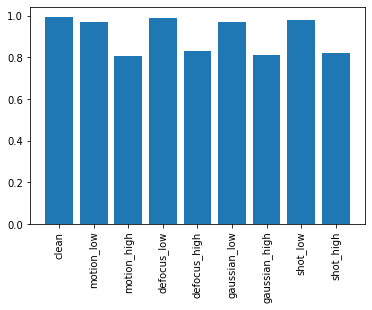

In [ ]:
#@title Run first finetuning and testing - only low noise model 

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
# model.load_state_dict(torch.load(path))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [motion_low_train,defocus_low_train,gaussian_low_train,shot_low_train]
dataset_list_test = [motion_low_test,defocus_low_test,gaussian_low_test,shot_low_test]

model_save_name = 'alltypes_low_model_finetune_test_incl'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =50)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/low_noise_model_test_acc_VGG19.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)

In [ ]:
#@title Load fresh VGG19 model
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)

20
[1] epoch. Loss: 83.620. Training accuracy: 0.800 . Test accuracy: 0.865
[2] epoch. Loss: 46.093. Training accuracy: 0.970 . Test accuracy: 0.887
[3] epoch. Loss: 30.342. Training accuracy: 0.970 . Test accuracy: 0.892
[4] epoch. Loss: 24.673. Training accuracy: 0.920 . Test accuracy: 0.897
[5] epoch. Loss: 20.371. Training accuracy: 0.970 . Test accuracy: 0.897
[6] epoch. Loss: 16.507. Training accuracy: 0.970 . Test accuracy: 0.910
[7] epoch. Loss: 14.165. Training accuracy: 0.970 . Test accuracy: 0.907
[8] epoch. Loss: 11.460. Training accuracy: 0.980 . Test accuracy: 0.913
[9] epoch. Loss: 12.806. Training accuracy: 0.990 . Test accuracy: 0.906
[10] epoch. Loss: 8.321. Training accuracy: 0.990 . Test accuracy: 0.919
[11] epoch. Loss: 9.662. Training accuracy: 0.980 . Test accuracy: 0.890
[12] epoch. Loss: 9.860. Training accuracy: 1.000 . Test accuracy: 0.908
[13] epoch. Loss: 10.687. Training accuracy: 1.000 . Test accuracy: 0.917
[14] epoch. Loss: 8.745. Training accuracy: 0.9

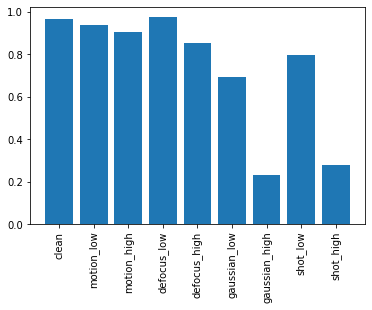

In [ ]:
#@title Run first finetuning and testing - only motion blur model 

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
# model.load_state_dict(torch.load(path))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [motion_low_train, motion_high_train]
dataset_list_test = [motion_low_test, motion_high_test]

model_save_name = 'motion_blur_all_severity_model'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =50)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/'+ model_save_name+ '_test_acc.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)

In [ ]:
#@title Load fresh VGG19 model
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)

20
[1] epoch. Loss: 110.258. Training accuracy: 0.840 . Test accuracy: 0.805
[2] epoch. Loss: 57.624. Training accuracy: 0.900 . Test accuracy: 0.846
[3] epoch. Loss: 38.721. Training accuracy: 0.920 . Test accuracy: 0.839
[4] epoch. Loss: 27.616. Training accuracy: 0.970 . Test accuracy: 0.864
[5] epoch. Loss: 22.612. Training accuracy: 0.920 . Test accuracy: 0.839
[6] epoch. Loss: 20.620. Training accuracy: 0.940 . Test accuracy: 0.894
[7] epoch. Loss: 15.660. Training accuracy: 0.980 . Test accuracy: 0.881
[8] epoch. Loss: 14.898. Training accuracy: 0.980 . Test accuracy: 0.893
[9] epoch. Loss: 10.859. Training accuracy: 1.000 . Test accuracy: 0.875
[10] epoch. Loss: 11.361. Training accuracy: 0.980 . Test accuracy: 0.887
[11] epoch. Loss: 9.704. Training accuracy: 0.980 . Test accuracy: 0.882
[12] epoch. Loss: 10.025. Training accuracy: 0.970 . Test accuracy: 0.868
[13] epoch. Loss: 9.217. Training accuracy: 0.980 . Test accuracy: 0.870
[14] epoch. Loss: 8.510. Training accuracy: 0

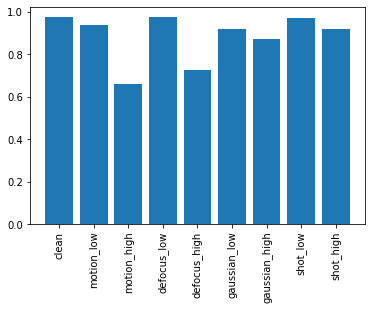

In [ ]:
#@title Run first finetuning and testing - only high and low gaussian noise model

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
# model.load_state_dict(torch.load(path))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [gaussian_low_train, gaussian_high_train]
dataset_list_test = [gaussian_low_test, gaussian_high_test]

model_save_name = 'gaussian_blur_all_severity_model'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =50)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/'+ model_save_name+ '_test_acc.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)

In [ ]:
#@title Load fresh VGG19 model
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)

20
[1] epoch. Loss: 176.401. Training accuracy: 0.900 . Test accuracy: 0.865
[2] epoch. Loss: 82.088. Training accuracy: 0.970 . Test accuracy: 0.918
[3] epoch. Loss: 49.335. Training accuracy: 0.970 . Test accuracy: 0.934
[4] epoch. Loss: 36.620. Training accuracy: 0.950 . Test accuracy: 0.939
[5] epoch. Loss: 33.013. Training accuracy: 0.980 . Test accuracy: 0.944
[6] epoch. Loss: 22.347. Training accuracy: 0.990 . Test accuracy: 0.953
[7] epoch. Loss: 18.597. Training accuracy: 0.960 . Test accuracy: 0.950
[8] epoch. Loss: 18.944. Training accuracy: 1.000 . Test accuracy: 0.961
[9] epoch. Loss: 19.220. Training accuracy: 0.970 . Test accuracy: 0.959
[10] epoch. Loss: 14.948. Training accuracy: 0.980 . Test accuracy: 0.968
[11] epoch. Loss: 13.844. Training accuracy: 1.000 . Test accuracy: 0.948
[12] epoch. Loss: 14.992. Training accuracy: 0.980 . Test accuracy: 0.957
[13] epoch. Loss: 10.806. Training accuracy: 0.990 . Test accuracy: 0.962
[14] epoch. Loss: 12.320. Training accuracy

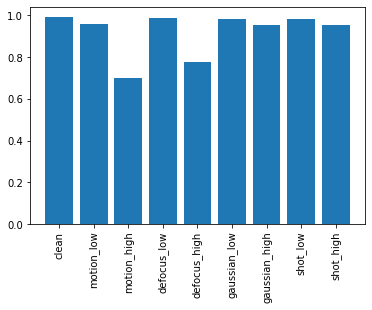

In [ ]:
#@title Run first finetuning and testing - all noise model

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
# model.load_state_dict(torch.load(path))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [gaussian_low_train, gaussian_high_train, shot_low_train, shot_high_train]
dataset_list_test = [gaussian_low_test, gaussian_high_test, shot_low_test, shot_high_test]

model_save_name = 'all_noise_all_severity_model'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =50)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/'+ model_save_name+ '_test_acc.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)

In [ ]:
#@title Load fresh VGG19 model
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=True)

20
[1] epoch. Loss: 145.250. Training accuracy: 0.900 . Test accuracy: 0.886
[2] epoch. Loss: 69.254. Training accuracy: 0.960 . Test accuracy: 0.927
[3] epoch. Loss: 45.113. Training accuracy: 0.960 . Test accuracy: 0.945
[4] epoch. Loss: 35.376. Training accuracy: 0.970 . Test accuracy: 0.944
[5] epoch. Loss: 29.234. Training accuracy: 0.970 . Test accuracy: 0.951
[6] epoch. Loss: 21.126. Training accuracy: 0.950 . Test accuracy: 0.945
[7] epoch. Loss: 20.853. Training accuracy: 0.970 . Test accuracy: 0.956
[8] epoch. Loss: 18.724. Training accuracy: 0.990 . Test accuracy: 0.958
[9] epoch. Loss: 19.704. Training accuracy: 0.980 . Test accuracy: 0.958
[10] epoch. Loss: 14.183. Training accuracy: 0.980 . Test accuracy: 0.974
[11] epoch. Loss: 12.024. Training accuracy: 1.000 . Test accuracy: 0.960
[12] epoch. Loss: 14.972. Training accuracy: 0.980 . Test accuracy: 0.956
[13] epoch. Loss: 13.132. Training accuracy: 1.000 . Test accuracy: 0.966
[14] epoch. Loss: 14.855. Training accuracy

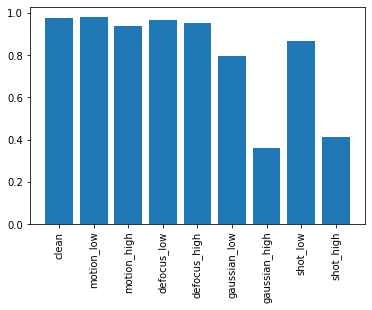

In [ ]:
#@title Run first finetuning and testing - all blur model

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
# model.load_state_dict(torch.load(path))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [motion_low_train,motion_high_train, defocus_low_train, defocus_high_train]
dataset_list_test = [motion_low_test, motion_high_test, defocus_low_test, defocus_high_test]

model_save_name = 'all_blur_all_severity_model'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =50)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/'+ model_save_name+ '_test_acc.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)

In [ ]:
#@title Load fresh VGG19 model without pretraining
#! git clone 'https://github.com/huyvnphan/PyTorch_CIFAR10.git' 

#! python ./PyTorch_CIFAR10/train.py --download_weights 1

from PyTorch_CIFAR10.cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
model = vgg19_bn()

# Pretrained model
model = vgg19_bn(pretrained=False)

200
[1] epoch. Loss: 838.172. Training accuracy: 0.710 . Test accuracy: 0.724
[2] epoch. Loss: 308.467. Training accuracy: 0.890 . Test accuracy: 0.831
[3] epoch. Loss: 119.021. Training accuracy: 0.950 . Test accuracy: 0.935
[4] epoch. Loss: 71.637. Training accuracy: 0.980 . Test accuracy: 0.943
[5] epoch. Loss: 53.700. Training accuracy: 0.980 . Test accuracy: 0.955
[6] epoch. Loss: 46.762. Training accuracy: 0.970 . Test accuracy: 0.964
[7] epoch. Loss: 41.226. Training accuracy: 0.990 . Test accuracy: 0.968
[8] epoch. Loss: 36.461. Training accuracy: 0.980 . Test accuracy: 0.963
[9] epoch. Loss: 35.485. Training accuracy: 0.990 . Test accuracy: 0.956
[10] epoch. Loss: 30.585. Training accuracy: 0.990 . Test accuracy: 0.973
[11] epoch. Loss: 30.994. Training accuracy: 0.960 . Test accuracy: 0.978
[12] epoch. Loss: 27.877. Training accuracy: 1.000 . Test accuracy: 0.975
[13] epoch. Loss: 27.711. Training accuracy: 1.000 . Test accuracy: 0.964
[14] epoch. Loss: 24.063. Training accur

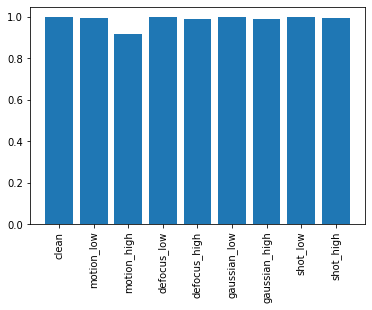

In [ ]:
#@title Run first finetuning and testing - impaired vision model 

# path = 'drive/MyDrive/NMA_DL_project/model-fold-2.pth'
# model = CNOTP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
dataset_list_train = [motion_low_train,motion_high_train, defocus_low_train, defocus_high_train, gaussian_low_train, gaussian_high_train, shot_low_train, shot_high_train]
dataset_list_test = [motion_low_test, motion_high_test, defocus_low_test, defocus_high_test,gaussian_low_test, gaussian_high_test, shot_low_test, shot_high_test]

model_save_name = 'impaired_vision_model'

finetuning (model, optimizer, criterion, dataset_list_train, dataset_list_test,model_save_name, batch_size=100, num_epochs =200)

fig_savepath = '/content/drive/MyDrive/NMA_DL_project/'+ model_save_name+ '_test_acc.png'

test_accuracies = test_function(model,fig_savepath,res_savepath,
                               clean = testset, 
                               motion_low = motion_low_test, 
                               motion_high = motion_high_test, 
                               defocus_low = defocus_low_test,
                               defocus_high = defocus_high_test, 
                               gaussian_low = gaussian_low_test,
                               gaussian_high = gaussian_high_test,
                               shot_low = shot_low_test,
                               shot_high = shot_high_test)